In [1]:
import json
import requests
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import pandas as pd
import random
import glob
import zipfile
import os
import shutil

In [2]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [3]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [4]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [5]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)


In [6]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [7]:
def osrm_route_request(from_place, to_place):
    url_coords = '{}{},{};{},{}' \
        .format('http://0.0.0.0:5000/route/v1/driving/',
                from_place.get('lon'), from_place.get('lat'), to_place.get('lon'), to_place.get('lat'))
    url_full = url_coords + '?annotations=true&geometries=geojson&steps=true'
    resp = requests.get(url=url_full)
    return _parse_osrm_response(resp)


def _parse_osrm_response(resp):
    # if resp.status_code != requests.codes.ok:
    #     resp.raise_for_status()

    jresp = resp.json()
    # if jresp.get('code') != 'Ok':
    #     log.error(jresp.get('code'))
    #     log.error(jresp.get('message'))
    #     resp.raise_for_status()

    trip = Trip()
    trip.legs = [Leg()]
    trip.legs[0].steps = []

    legs = jresp.get('routes')[0].get('legs')
    for leg in legs:
        steps = leg.get('steps')
        for step in steps:
            new_step = Step(distance=step.get('distance'),
                            duration=step.get('duration'),
                            start_coord=Coord(lon=step.get('geometry').get('coordinates')[0][0],
                                              lat=step.get('geometry').get('coordinates')[0][1]),
                            end_coord=Coord(lon=step.get('geometry').get('coordinates')[-1][0],
                                            lat=step.get('geometry').get('coordinates')[-1][1]))
            # OSRM makes circles on roundabouts. And makes empty step in the end. Exclude these cases from a route
            if new_step.start_coord != new_step.end_coord:
                trip.legs[0].steps.append(new_step)
        if len(trip.legs[0].steps) == 0:
            waypoints = jresp.get('waypoints')
            trip.legs[0].steps.append(Step(distance=0,
                                           duration=0,
                                           start_coord=Coord(lon=waypoints[0].get('location')[0],
                                                             lat=waypoints[0].get('location')[1]),
                                           end_coord=Coord(lon=waypoints[1].get('location')[0],
                                                           lat=waypoints[1].get('location')[1])
                                           )
                                      )
    trip.legs[0].start_coord = trip.legs[0].steps[0].start_coord
    trip.legs[0].end_coord = trip.legs[0].steps[-1].end_coord
    trip.legs[0].duration = sum([step.duration for step in trip.legs[0].steps])
    trip.legs[0].distance = sum([step.distance for step in trip.legs[0].steps])
    trip.legs[0].mode = OtpMode.DRT

    trip.distance = trip.legs[0].distance
    trip.duration = trip.legs[0].duration
    trip.main_mode = OtpMode.CAR
    return trip


In [8]:
fp = open('data/population_VEHITS_divided_to_pt_and_others_kommun_cut_work_distr.json')
tdump_pop = json.load(fp)
fp.close()

In [19]:
tdump_pop.keys()

dict_keys(['population_within_pt', 'population_within_other', 'population_in_pt', 'population_out_pt', 'population_in_drtable', 'population_out_drtable', 'population_in_other', 'population_out_other'])

In [32]:
pwithin_PT = tdump_pop['population_within_pt']
pwithin_OT = tdump_pop['population_within_other']
pwithin = pwithin_OT + pwithin_PT

In [33]:
pout = tdump_pop['population_in_drtable'] + tdump_pop['population_out_drtable']

In [34]:
direct_trips = []
for person in pwithin:
    a = {'start_coord': person['activities'][0]['coord'], 'end_coord': person['activities'][1]['coord']}
    direct_trips.append(a)
direct_trips = [osrm_route_request(leg.get('start_coord'), leg.get('end_coord')) for leg in direct_trips]

In [35]:
distances = [d.distance / 1000 for d in direct_trips]

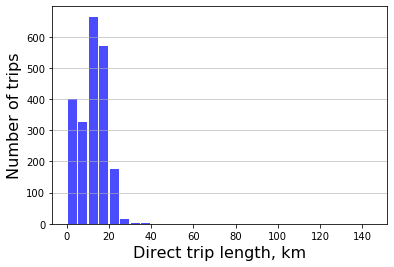

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=distances, bins=np.arange(0,150,5), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Direct trip length, km', {'fontsize': 16})
plt.ylabel('Number of trips', {'fontsize': 16})
# plt.title('"Waiting" time, DRT', {'fontsize': 18})
# plt.ylim([0,80])
plt.savefig('data/demand_distance_distr_sw.svg', dpi=600)

In [37]:
direct_trips = []
for person in pout:
    a = {'start_coord': person['activities'][0]['coord'], 'end_coord': person['activities'][1]['coord']}
    direct_trips.append(a)
direct_trips = [osrm_route_request(leg.get('start_coord'), leg.get('end_coord')) for leg in direct_trips]

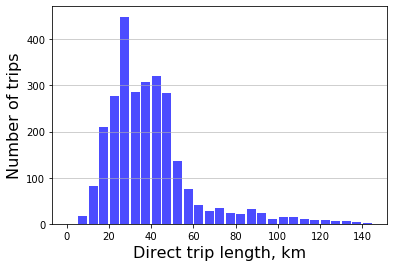

In [39]:
distances = [d.distance / 1000 for d in direct_trips]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=distances, bins=np.arange(0,150,5), color='blue', alpha=0.7, rwidth=0.85, density=False)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Direct trip length, km', {'fontsize': 16})
plt.ylabel('Number of trips', {'fontsize': 16})
# plt.title('"Waiting" time, DRT', {'fontsize': 18})
# plt.ylim([0,80])
plt.savefig('data/demand_distance_distr_so.svg', dpi=600)